In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns
import plotly.express as px
from scipy import stats
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
import datetime
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('monthly_disease_outbreak.csv')

## Basic information about the dataset 

In [5]:
print("Shape of dataset:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Rows:\n", df.head(10))

Shape of dataset: (8985, 13)

Column Names:
 ['unnamed: 0', 'week_of_outbreak', 'state_ut', 'district', 'disease', 'cases', 'deaths', 'latitude', 'longitude', 'preci', 'lai', 'temp_c', 'date']

Data Types:
 unnamed: 0            int64
week_of_outbreak     object
state_ut             object
district             object
disease              object
cases                object
deaths              float64
latitude            float64
longitude           float64
preci               float64
lai                 float64
temp_c              float64
date                 object
dtype: object

Missing Values:
 unnamed: 0             0
week_of_outbreak       0
state_ut               0
district               0
disease                0
cases                  0
deaths              6431
latitude               0
longitude              0
preci                136
lai                 2195
temp_c               938
date                   0
dtype: int64

Sample Rows:
    unnamed: 0 week_of_outbreak       state_u

In [6]:
print(plt.style.available)
mpl.style.use(['ggplot'])

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [7]:
df[~df['cases'].str.replace('.', '', regex=False).str.isnumeric()]['cases'].unique()


array(['03-Jan'], dtype=object)

In [8]:
# Coerce non-numeric to NaN
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')


In [9]:
df['cases'] = df['cases'].astype('float')
df['date'] = pd.to_datetime(df['date'])

In [10]:
print(df[['cases', 'date']].isna().sum())


cases    1
date     0
dtype: int64


In [11]:
df['cases'].fillna(0, inplace=True)  


In [12]:
df.disease.unique()

array(['Acute Diarrhoeal Disease', 'Malaria',
       'Acute Encephalitis Syndrome', 'Acute Gastroenteritis', 'Dengue',
       'Pyrexia Of Unknown Origin', 'Chikungunya', 'Cholera',
       'Malaria (Pv)', 'Dengue Fever', 'Suspected Dengue',
       'Dengue Chikungunya', 'Dengue And Chikungunya',
       'Suspected Cholera', 'Diarrhea', 'Suspected Chikungunya',
       'Suspected Dengue And Chikungunya', 'Gastroenteritis',
       'Dengue And Malaria', 'Dengue/Chikungunya', 'Chikungunya/Dengue',
       'Chikungunya/ Dengue'], dtype=object)

In [13]:
# Fix cases variable
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')  # force numeric, make invalid ones NaN

df = df.dropna(subset=['cases'])  

df['year'] = pd.to_datetime(df['date']).dt.year
cases_per_year = df.groupby('year')['cases'].sum().reset_index()
print(cases_per_year)


    year     cases
0   2009   90377.0
1   2010   59122.0
2   2011   66707.0
3   2012   60331.0
4   2013   50772.0
5   2014   60816.0
6   2015  139547.0
7   2016   76191.0
8   2017   49737.0
9   2018   76139.0
10  2019   29951.0
11  2020    5594.0
12  2021   22127.0
13  2022    9016.0


## Disease outbreak trend across years 

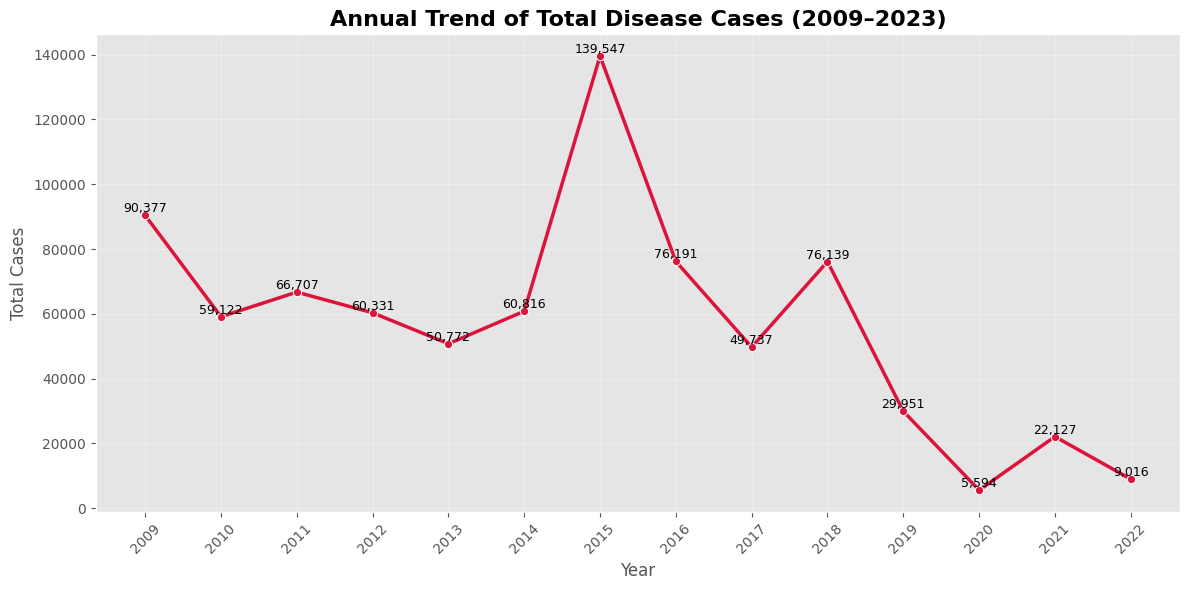

In [14]:
df['year'] = pd.to_datetime(df['date']).dt.year
cases_per_year = df.groupby('year')['cases'].sum().reset_index()

# Total cases per year
plt.figure(figsize=(12, 6))
sns.lineplot(data=cases_per_year, x='year', y='cases', marker='o', linewidth=2.5, color='crimson')
plt.title('Annual Trend of Total Disease Cases (2009–2023)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Cases', fontsize=12)
plt.xticks(cases_per_year['year'], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add data labels
for x, y in zip(cases_per_year['year'], cases_per_year['cases']):
    plt.text(x, y, f'{int(y):,}', ha='center', va='bottom', fontsize=9, color='black')

plt.show()


## Top 10 diseases by case count

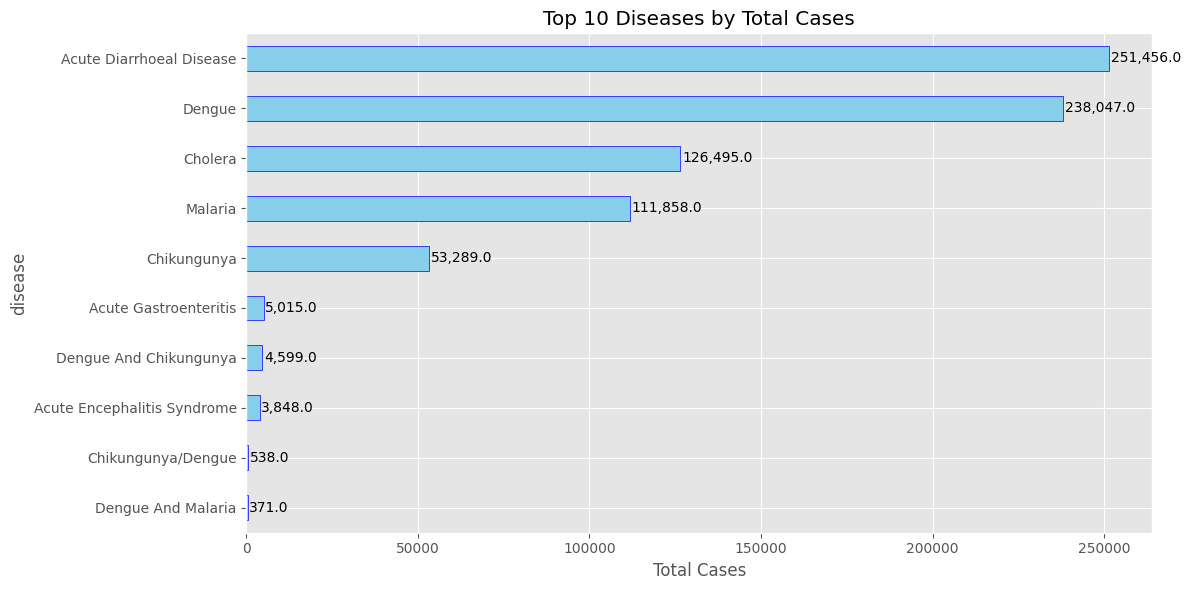

In [15]:
df['disease'] = df['disease'].astype(str).str.strip().str.title()

# Group and get total cases
top_diseases = df.groupby('disease')['cases'].sum()

# Sort and select top 10
top_diseases = top_diseases.sort_values(ascending=False).head(10)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_diseases.sort_values().plot(kind='barh', color='skyblue', edgecolor='blue')

for i, value in enumerate(top_diseases.sort_values()):
    plt.text(value + 500, i, f'{value:,}', va='center')

plt.title('Top 10 Diseases by Total Cases')
plt.xlabel('Total Cases')
plt.tight_layout()
plt.show()

In [16]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'berlin',
 'managua',
 'vanimo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',

## Leading 5 states with disease count and detailed breakdown

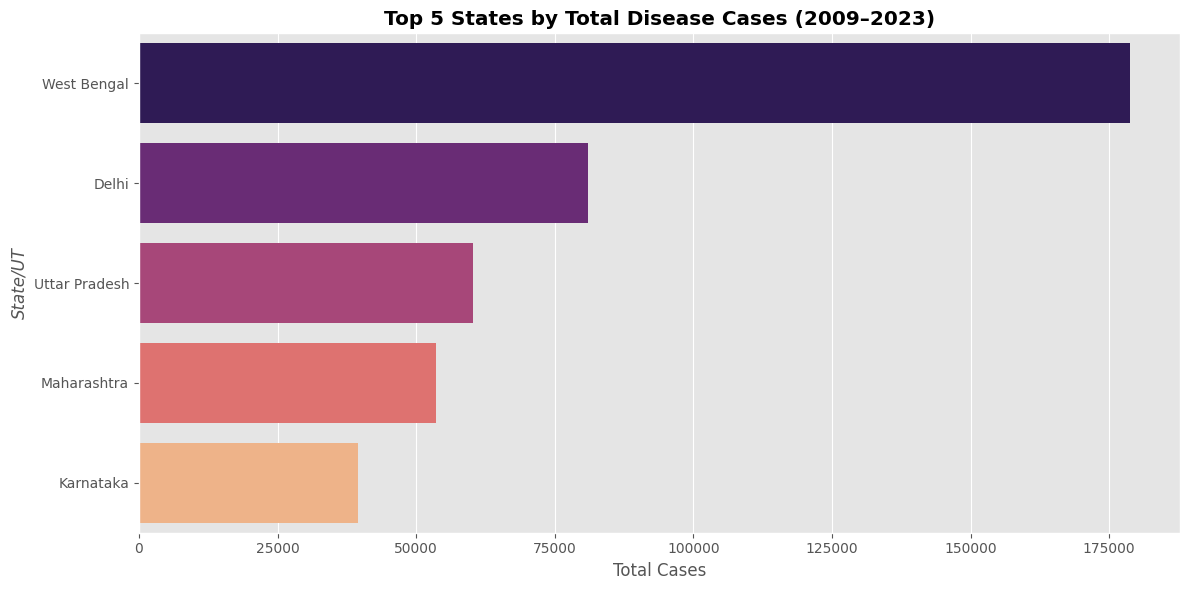

TOP 5 STATES BY TOTAL DISEASE CASES (2009-2023)
1. West Bengal: 178,830 cases
2. Delhi: 80,933 cases
3. Uttar Pradesh: 60,173 cases
4. Maharashtra: 53,575 cases
5. Karnataka: 39,532 cases

DETAILED BREAKDOWN:
----------------------------------------
Rank 1: West Bengal
  Total Cases: 178,830
  Percentage of Top 5: 43.3%

Rank 2: Delhi
  Total Cases: 80,933
  Percentage of Top 5: 19.6%

Rank 3: Uttar Pradesh
  Total Cases: 60,173
  Percentage of Top 5: 14.6%

Rank 4: Maharashtra
  Total Cases: 53,575
  Percentage of Top 5: 13.0%

Rank 5: Karnataka
  Total Cases: 39,532
  Percentage of Top 5: 9.6%

Total cases in Top 5 states: 413,043
Total cases overall: 796,427
Top 5 states represent 51.9% of all cases


In [17]:
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')

# Extract year 
df['year'] = pd.to_datetime(df['date']).dt.year

state_cases = df.groupby('state_ut')['cases'].sum().sort_values(ascending=False).reset_index()

# Top 5 states
top_5_states = state_cases.head(5)

# Plot: Top 5 states by total disease cases
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5_states, x='cases', y='state_ut', palette='magma')

# --- MODIFICATIONS START HERE ---
plt.title('Top 5 States by Total Disease Cases (2009–2023)', fontweight='bold') 
plt.xlabel('Total Cases')
plt.ylabel('State/UT', fontstyle='italic') 
# --- MODIFICATIONS END HERE ---

plt.tight_layout()
plt.show()

# ========== NEW CODE: Extract and Display Exact Numbers ==========

print("=" * 60)
print("TOP 5 STATES BY TOTAL DISEASE CASES (2009-2023)")
print("=" * 60)

# Display the exact numbers for top 5 states
for i, row in top_5_states.iterrows():
    rank = i + 1
    state = row['state_ut']
    cases = int(row['cases'])  
    print(f"{rank}. {state}: {cases:,} cases")

print("=" * 60)

#  More detailed formatting
print("\nDETAILED BREAKDOWN:")
print("-" * 40)
total_cases_top5 = top_5_states['cases'].sum()

for i, row in top_5_states.iterrows():
    rank = i + 1
    state = row['state_ut']
    cases = int(row['cases'])
    percentage = (cases / total_cases_top5) * 100
    print(f"Rank {rank}: {state}")
    print(f"  Total Cases: {cases:,}")
    print(f"  Percentage of Top 5: {percentage:.1f}%")
    print()

print(f"Total cases in Top 5 states: {int(total_cases_top5):,}")
print(f"Total cases overall: {int(df['cases'].sum()):,}")
print(f"Top 5 states represent {(total_cases_top5/df['cases'].sum())*100:.1f}% of all cases")

## Pie Chart + Detailed Breakdown

🔍 DATA VALIDATION & EXPLORATION
📊 Dataset Overview:
   • Total records: 8,985
   • Date range: 2009-05-04 00:00:00 to 2022-06-29 00:00:00
   • Years covered: 2009 - 2022
   • Unique diseases: 22
   • Missing values in 'cases': 0
   • Zero/negative cases: 1

📋 All Diseases in Dataset (22 total):
    1. Acute Diarrhoeal Disease: 5,126 records, 251,456.0 total cases
    2. Dengue: 1,619 records, 238,047.0 total cases
    3. Chikungunya: 731 records, 53,289.0 total cases
    4. Cholera: 666 records, 126,495.0 total cases
    5. Malaria: 544 records, 111,858.0 total cases
    6. Acute Encephalitis Syndrome: 111 records, 3,848.0 total cases
    7. Acute Gastroenteritis: 100 records, 5,015.0 total cases
    8. Dengue And Chikungunya: 53 records, 4,599.0 total cases
    9. Suspected Dengue: 14 records, 291.0 total cases
   10. Dengue And Malaria: 3 records, 371.0 total cases
   11. Suspected Chikungunya: 3 records, 54.0 total cases
   12. Dengue/Chikungunya: 3 records, 74.0 total cases
   13. 

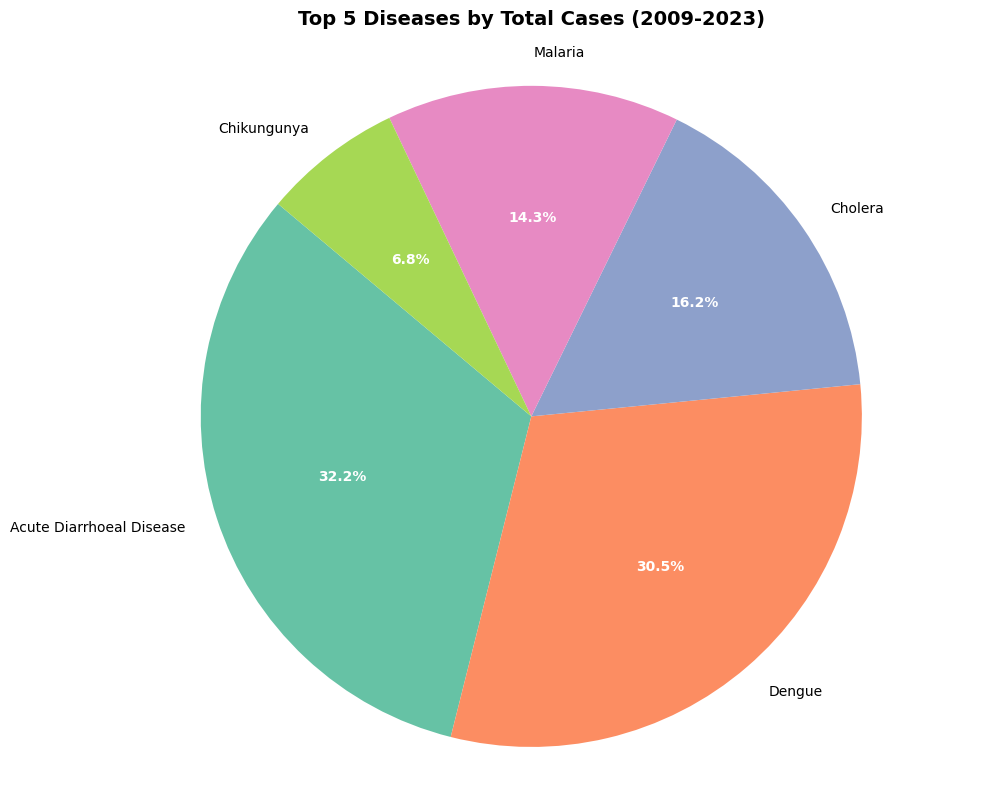


📅 YEAR-WISE BREAKDOWN:
   Year | Total Cases
   -----|------------
   2009 |   90,377.0
   2010 |   59,122.0
   2011 |   66,707.0
   2012 |   60,331.0
   2013 |   50,772.0
   2014 |   60,816.0
   2015 |  139,547.0
   2016 |   76,191.0
   2017 |   49,737.0
   2018 |   76,139.0
   2019 |   29,951.0
   2020 |    5,594.0
   2021 |   22,127.0
   2022 |    9,016.0

⚠️  POTENTIAL DATA QUALITY ISSUES:
   • 13 diseases have <10 records

🔍 COMPARISON WITH RESEARCH PAPER:

🧭 PEAK SEASONS FOR TOP 5 DISEASES:
   🔹 Acute Diarrhoeal Disease: Early Monsoon (peak in month 7)
   🔹 Dengue: Early Monsoon (peak in month 7)
   🔹 Cholera: Summer (peak in month 5)
   🔹 Malaria: Post Monsoon (peak in month 9)
   🔹 Chikungunya: Peak Monsoon (peak in month 8)


In [18]:
# Ensure date is in datetime format and extract month
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

print("🔍 DATA VALIDATION & EXPLORATION")
print("=" * 50)

# 1. Check data quality and coverage
print(f"📊 Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   • Years covered: {df['year'].min()} - {df['year'].max()}")
print(f"   • Unique diseases: {df['disease'].nunique()}")
print(f"   • Missing values in 'cases': {df['cases'].isna().sum()}")
print(f"   • Zero/negative cases: {(df['cases'] <= 0).sum()}")

# 2. Show all diseases in dataset
print(f"\n📋 All Diseases in Dataset ({df['disease'].nunique()} total):")
all_diseases = df['disease'].value_counts()
for i, (disease, count) in enumerate(all_diseases.items(), 1):
    total_cases = df[df['disease'] == disease]['cases'].sum()
    print(f"   {i:2d}. {disease}: {count:,} records, {total_cases:,} total cases")

# 3. Clean and validate cases data
print(f"\n🧹 DATA CLEANING:")
original_rows = len(df)

# Remove rows with invalid dates
df = df.dropna(subset=['date'])
print(f"   • Removed {original_rows - len(df)} rows with invalid dates")

# Handle missing/invalid cases
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df = df.dropna(subset=['cases'])
print(f"   • Removed rows with invalid case numbers")

# Filter for positive cases only
df = df[df['cases'] > 0]
print(f"   • Filtered to positive cases only")
print(f"   • Final dataset: {len(df):,} records")

# 4. Aggregate total cases per disease
print(f"\n📈 TOP 5 DISEASES ANALYSIS:")
top_diseases = df.groupby('disease')['cases'].sum().sort_values(ascending=False).head(5)

total_all_cases = df['cases'].sum()
print("   Rank | Disease                    | Total Cases  | Percentage")
print("   -----|----------------------------|--------------|----------")
for i, (disease, cases) in enumerate(top_diseases.items(), 1):
    percentage = (cases / total_all_cases) * 100
    print(f"   {i:2d}   | {disease:<26} | {cases:>10,} | {percentage:>7.1f}%")

print(f"\n   Total cases (all diseases): {total_all_cases:,}")
print(f"   Top 5 represent: {(top_diseases.sum()/total_all_cases)*100:.1f}% of all cases")

# 5. Plot pie chart of top 5 diseases
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(top_diseases))
wedges, texts, autotexts = plt.pie(top_diseases, labels=top_diseases.index, autopct='%1.1f%%', 
                                   startangle=140, colors=colors)

# Enhance text formatting
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.title("Top 5 Diseases by Total Cases (2009-2023)", fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures pie is round
plt.tight_layout()
plt.show()

# 6. Year-wise analysis to check for trends
print(f"\n📅 YEAR-WISE BREAKDOWN:")
yearly_totals = df.groupby('year')['cases'].sum()
print("   Year | Total Cases")
print("   -----|------------")
for year, cases in yearly_totals.items():
    print(f"   {year} | {cases:>10,}")

# 7. Check for potential data issues
print(f"\n⚠️  POTENTIAL DATA QUALITY ISSUES:")

# Check for unusually high single-day cases
max_single_day = df.groupby(['date', 'disease'])['cases'].sum().max()
if max_single_day > 100000:  # Arbitrary threshold
    print(f"   • Very high single-day cases detected: {max_single_day:,}")
    
# Check for diseases with very few records
low_record_diseases = all_diseases[all_diseases < 10]
if len(low_record_diseases) > 0:
    print(f"   • {len(low_record_diseases)} diseases have <10 records")

# 8. Compare with research paper expectations
print(f"\n🔍 COMPARISON WITH RESEARCH PAPER:")
research_paper_ranking = ['Acute Diarrheal Disease', 'Dengue', 'Chikungunya', 'Cholera', 'Malaria']
your_ranking = top_diseases.index.tolist()

# Season analysis (your existing code)
season_map = {
    1: 'Winter', 2: 'Winter',
    3: 'Summer', 4: 'Summer', 5: 'Summer',
    6: 'Early Monsoon', 7: 'Early Monsoon',
    8: 'Peak Monsoon', 9: 'Post Monsoon',
    10: 'Post Monsoon', 11: 'Autumn', 12: 'Winter'
}

df['season'] = df['month'].map(season_map)

print(f"\n🧭 PEAK SEASONS FOR TOP 5 DISEASES:")
for disease in top_diseases.index:
    disease_df = df[df['disease'] == disease]
    peak_month = disease_df.groupby('month')['cases'].sum().idxmax()
    season = season_map.get(peak_month, 'Unknown')
    print(f"   🔹 {disease}: {season} (peak in month {peak_month})")

## Heatmap of Disease intensity (Top 10)


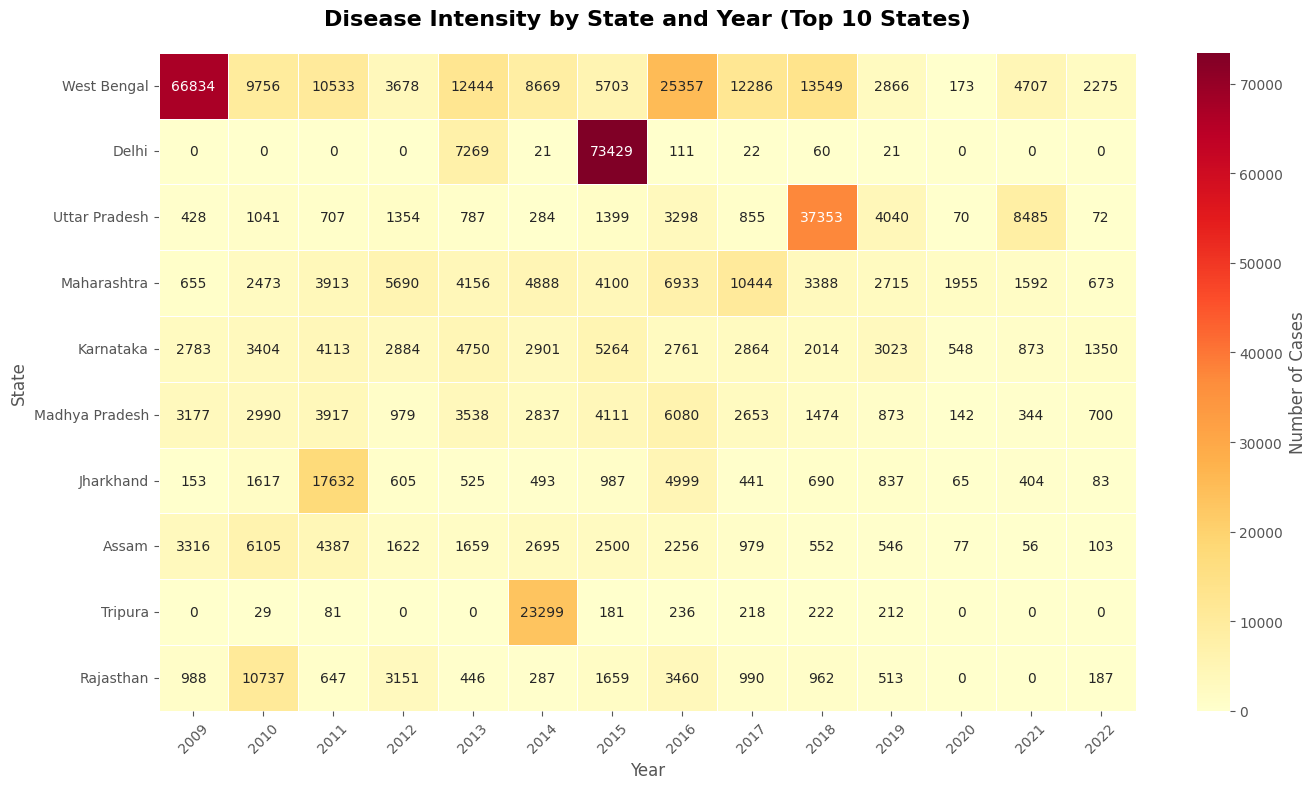

In [19]:
# Ensure proper formats
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['cases', 'date'])

# Extract year
df['year'] = df['date'].dt.year

# Group by state to get total cases and get top 10 states
top_states = df.groupby('state_ut')['cases'].sum().nlargest(10).index.tolist()

# Filter data for top 10 states
top_states_df = df[df['state_ut'].isin(top_states)]

# Pivot table: rows = state, columns = year, values = total cases
heatmap_data = top_states_df.groupby(['state_ut', 'year'])['cases'].sum().unstack(fill_value=0)

# Sort states by total cases (descending)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Set ggplot style
plt.style.use('ggplot')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    linewidths=0.4,
    linecolor='white',
    cbar_kws={'label': 'Number of Cases'}
)

plt.title('Disease Intensity by State and Year (Top 10 States)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Delhi

In [20]:
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['cases', 'date'])

df['year'] = df['date'].dt.year

# Filter for Delhi in 2015
delhi_2015 = df[(df['state_ut'].str.lower() == 'delhi') & (df['year'] == 2015)]

# Group by disease to get total cases
disease_counts = delhi_2015.groupby('disease')['cases'].sum().reset_index().sort_values(by='cases', ascending=False)

total_cases = delhi_2015['cases'].sum()

print("Disease-wise outbreak data for Delhi in 2015:\n")
print(disease_counts)
print(f"\nTotal number of cases in Delhi in 2015: {int(total_cases):,}")

Disease-wise outbreak data for Delhi in 2015:

                    disease    cases
1                    Dengue  73391.0
0  Acute Diarrhoeal Disease     38.0

Total number of cases in Delhi in 2015: 73,429


## Correlation : Cases vs Environmental Variables

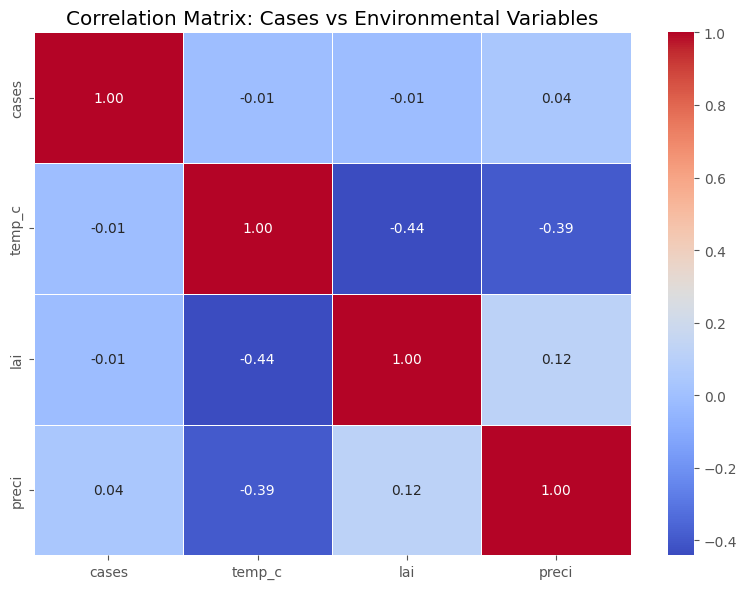


Summary:
- Correlation values range from -1 (perfect negative) to +1 (perfect positive).
- Strong correlations (>|0.6|) suggest potential linear relationships.
- Moderate (0.3-0.6) or weak (<0.3) correlations may still be useful in nonlinear models like Random Forests.


In [21]:
corr_data = df[['cases', 'temp_c', 'lai', 'preci']].copy()
corr_data = corr_data.dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Cases vs Environmental Variables')
plt.tight_layout()
plt.show()

# Interpretation summary
print("\nSummary:")
print("- Correlation values range from -1 (perfect negative) to +1 (perfect positive).")
print("- Strong correlations (>|0.6|) suggest potential linear relationships.")
print("- Moderate (0.3-0.6) or weak (<0.3) correlations may still be useful in nonlinear models like Random Forests.")

In [22]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================================
# 2. LINEAR REGRESSION FOR SIGNIFICANCE (P-VALUES)
# =============================================

print("\n" + "="*80)
print("2. LINEAR REGRESSION ANALYSIS")
print("="*80)

# Prepare data for regression
reg_data = corr_data.dropna()
X = reg_data[['temp_c', 'lai', 'preci']]
y = reg_data['cases']
X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()

# Show regression summary
print(ols_model.summary())

# Interpretation summary
print("\nSummary:")
print("- Look at the p-values under 'P>|t|':")
print("  * A p-value < 0.05 means the variable is statistically significant.")
print("  * Higher p-values suggest the variable may not significantly predict cases.")
print("- Also consider R-squared: it shows how much of the variance in 'cases' is explained by the model.")



2. LINEAR REGRESSION ANALYSIS
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.982
Date:                Fri, 13 Jun 2025   Prob (F-statistic):            0.00761
Time:                        20:05:55   Log-Likelihood:                -47336.
No. Observations:                5996   AIC:                         9.468e+04
Df Residuals:                    5992   BIC:                         9.471e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.3278